In [1]:
'''
    Author - Oyesh Mann Singh
    Date - 10/05/2018
    Description 
        - Nepali News Classification
        - Analyzing various ML algorithms
'''

import os
import sys
import time
import re
import string
import unicodecsv as csv
import unicodedata as un
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

In [2]:
# Reading train/text files
pd_train = pd.read_csv('./data/raw/train.csv')
pd_test = pd.read_csv('./data/raw/test.csv')

In [3]:
classes = ['Auto', 'Bank', 'Blog', 'Business Interview',
           'Economy', 'Education', 'Employment', 'Entertainment',
           'Interview', 'Literature', 'National News', 'Opinion',
           'Sports', 'Technology', 'Tourism', 'World']

In [4]:
print(len(pd_train))
print(len(pd_test))

10594
3531


Text(0.5,0,'Labels')

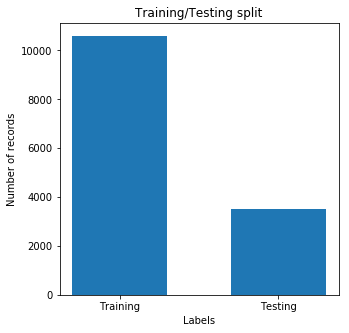

In [5]:
# Plotting training/testing dataset distribution

f, ax = plt.subplots(figsize=(5,5))

labels = ['Training', 'Testing']
counts = [len(pd_train), len(pd_test)]

ax.bar(x=labels, height=counts, width=0.60)
ax.set_title('Training/Testing split')
ax.set_ylabel('Number of records')
ax.set_xlabel('Labels')


# ax1.bar(x=classes, height=pd_train.groupby('label').data.count().values)
# ax2.bar(x=classes, height=pd_test.groupby('label').data.count().values)

# ax1.set_xticklabels(classes, rotation=90)
# ax1.set_title('Training dataset')
# ax1.set_ylabel('Number of records')
# ax1.set_xlabel('Labels')

# ax2.set_xticklabels(classes, rotation=90)
# ax2.set_title('Testing dataset')
# ax2.set_ylabel('Number of records')
# ax2.set_xlabel('Labels')

# f.tight_layout()
# plt.show()

In [6]:
pd_train.shape

(10594, 2)

In [7]:
pd_train.head()

,label,data
0,10,थारु सभासदहरुले कैलालीको टीकापुरमा भएको झडपमा ...
1,10,राजविराज चैत सप्तरी प्रहरीले पातो गाविसबाट स...
2,1,गजेन्द्र बुढाथोकीकाठमाडौं माघ बैंकिङ क्षेत्र...
3,10,उपप्रधानमन्त्री कमल थापाले संविधानमा असहमति हु...
4,10,असोज काठमाडौं अमेरिकी अधिकारीहरुले आधिकारिक ...


In [8]:
pd_train.label.unique()

array([10,  1,  7, 12,  3,  2, 11, 15,  4, 14,  0,  6,  8, 13,  5,  9])

In [9]:
# Check the number of records for each label
pd_train.groupby('label').count()

,data
label,
0,68
1,270
2,161
3,108
4,878
5,65
6,108
7,881
8,65


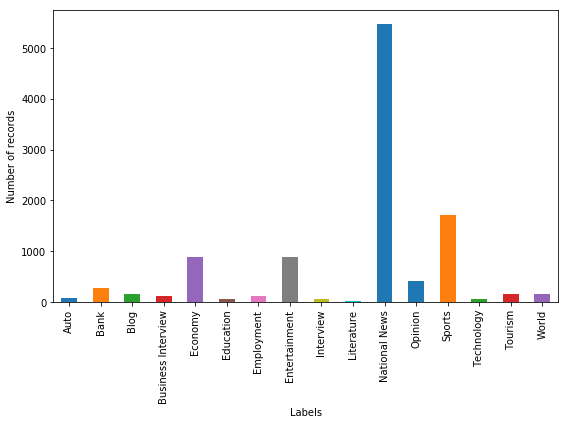

In [10]:
'''
    Plotting training dataset
'''
import matplotlib.pyplot as plt

def histogram_by_label(train_set):
    fig, ax = plt.subplots(figsize=(8,6))

    train_set.groupby('label').data.count().plot.bar(ylim=0)

    ax.set_xticklabels(classes, rotation=90)
    ax.set_ylabel('Number of records')
    ax.set_xlabel('Labels')
    fig.tight_layout()
    plt.show()

histogram_by_label(pd_train)

In [11]:
pd_train_1 = pd_train[(pd_train.label != 10) & (pd_train.label != 12) & (pd_train.label != 4) & (pd_train.label != 7)]

In [12]:
pd_train_1.groupby('label').count()

,data
label,
0,68
1,270
2,161
3,108
5,65
6,108
8,65
9,13
11,419


In [13]:
pd_train_1 = pd_train_1.append(pd_train.loc[pd_train.label == 10][:400])
pd_train_1 = pd_train_1.append(pd_train.loc[pd_train.label == 12][:400])
pd_train_1 = pd_train_1.append(pd_train.loc[pd_train.label == 4][:400])
pd_train_1 = pd_train_1.append(pd_train.loc[pd_train.label == 7][:400])

In [14]:
pd_train_1.groupby('label').count()

,data
label,
0,68
1,270
2,161
3,108
4,400
5,65
6,108
7,400
8,65


# BALANCE THE DATASET

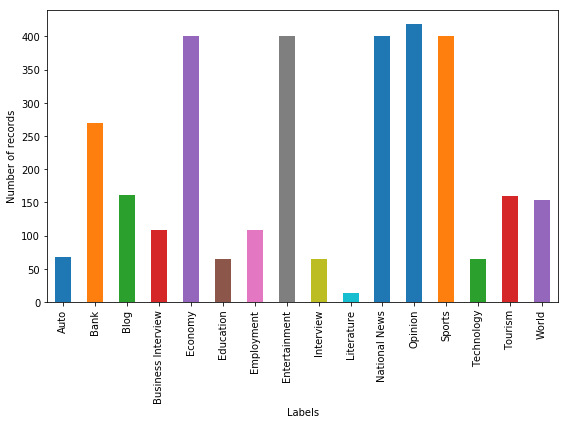

In [15]:
histogram_by_label(pd_train_1)

In [16]:
pd_train = pd_train_1

In [17]:
train_token_count = 0
test_token_count = 0

for each_row in pd_train['data']:
    train_token_count += len(each_row)
    
for each_row in pd_test['data']:
    test_token_count += len(each_row)

print("Number of tokens in train = ", train_token_count)
print("Number of tokens in test = ", test_token_count)

Number of tokens in train =  8122101
Number of tokens in test =  6874718


In [18]:
print("Avg Number of tokens in each sentence in train = ", train_token_count/pd_train.shape[0])
print("Avg Number of tokens in each sentence in test = ", test_token_count/pd_test.shape[0])

Avg Number of tokens in each sentence in train =  2495.269124423963
Avg Number of tokens in each sentence in test =  1946.9606343811952


In [19]:
from nltk.util import ngrams
from collections import Counter

# Putting all data into a list
train_tokens_list = pd_train.data.tolist()
test_tokens_list = pd_test.data.tolist()

In [20]:
# Testing if the token_list can be easily tokenized
train_tokens_list[10].split()[5]

'पछिल्लो'

In [21]:
# Testing if the token_list can be easily tokenized
test_tokens_list[10].split()[5]

'प्रचण्डले'

In [22]:
tokens = []
for each in train_tokens_list:
    for i in each.split():
        tokens.append(i)

In [23]:
# Checking the most commong trigrams
text_trigrams = ngrams(tokens, 3)

Counter(text_trigrams).most_common(10)

[(('बैंक', 'तथा', 'वित्तीय'), 201),
 (('गर्ने', 'हो', 'भने'), 142),
 (('हुन', 'सकेको', 'छैन'), 131),
 (('करोड', 'लाख', 'हजार'), 131),
 (('गर्दै', 'आएको', 'छ'), 125),
 (('प्रमुख', 'कार्यकारी', 'अधिकृत'), 124),
 (('करोड', 'लाख', 'रुपैयाँ'), 118),
 (('उनको', 'भनाइ', 'छ'), 117),
 (('अर्ब', 'करोड', 'रुपैयाँ'), 115),
 (('अर्ब', 'करोड', 'लाख'), 115)]

In [24]:
# Checking the most commong bigrams
text_trigrams = ngrams(tokens, 2)

Counter(text_trigrams).most_common(10)

[(('भएको', 'छ'), 1913),
 (('गरेको', 'छ'), 1663),
 (('गरेका', 'छन्'), 1016),
 (('छ', 'तर'), 800),
 (('हो', 'भने'), 760),
 (('गरिएको', 'छ'), 735),
 (('भए', 'पनि'), 634),
 (('जनाएको', 'छ'), 633),
 (('छ', 'यो'), 625),
 (('आएको', 'छ'), 615)]

In [25]:
# Checking the most commong trigrams
text_unigram = ngrams(tokens, 1)

c = Counter(text_unigram)

c.most_common(10)

[(('छ',), 22632),
 (('र',), 22288),
 (('पनि',), 15142),
 (('हो',), 8650),
 (('छन्',), 7725),
 (('भने',), 6570),
 (('भएको',), 6545),
 (('लागि',), 6419),
 (('गर्न',), 6279),
 (('गर्ने',), 6034)]

In [26]:
# Get total count of unique words
print('Total count of unique tokens = ', len(c))

Total count of unique tokens =  124646


In [27]:
from nltk import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a tokenizer
tokenizer = TweetTokenizer()

In [28]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer.tokenize)

In [29]:
# Merge train and test list
full_text = train_tokens_list + test_tokens_list

In [30]:
unique_count = Counter(full_text)

In [31]:
%%time
vectorizer.fit(full_text)

CPU times: user 38.5 s, sys: 36 ms, total: 38.6 s
Wall time: 38.6 s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x3ffd0ebc0940>>,
        use_idf=True, vocabulary=None)

In [32]:
len(vectorizer.get_feature_names())

127113

In [33]:
print(vectorizer.get_feature_names()[1:10])

['à ààà', 'àªààà', 'àªààà àààªà', 'àªààà àšààà', 'àªàààµàà', 'àªàààµàà àààœàà', 'àµààà', 'àµààà ààà', 'àµàààµààà']


In [34]:
# Shuffle the data
pd_train = pd_train.sample(frac=1).reset_index(drop=True)
pd_test = pd_test.sample(frac=1).reset_index(drop=True)

In [35]:
# Check the data after shuffled
pd_train.head()

,label,data
0,8,नेपालको समथरमा जारी आन्दोलन अनपेक्षित होइन तर ...
1,15,भाद्र वेलायतले कटर पन्थी विद्रोहीको आक्रमणको...
2,7,उमेर पुगेका यूवा यूवतीहरुलाई यौन इच्छा बढि हुन...
3,7,काठमाडौँ पारि त्यो डाँडामा हेर घाम लाग्यो घमा...
4,3,राज्य संयन्त्र ग्यास र पेट्रोलयममा अड्किएको छ ...


In [36]:
# Transform our input train/test data
train_vectorized = vectorizer.transform(pd_train.data)
test_vectorized = vectorizer.transform(pd_test.data)

/home/osingh1/miniconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [37]:
# Check the shape of transformed vector
print(train_vectorized.shape)

(3255, 127113)


## REVIEW PREPARATION

In [38]:
# Testing with random new review
review = ["सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।",
         "आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।",
         "अर्ब ६३ करोड ६३ लाख ३९ हजार ५६० मूल्य बराबरको शेयर किनबेच भएको छ। नेपालस्टक एक्चेन्ज(नेप्से) परिसूचक साताभारमा १७ अंकले बढेको छ।"]

# Print the prediction of new reviews
def print_prediction(review, est):
    print("*****EVALUATE REVIEW*******")
    review_vectorized = vectorizer.transform(review)
    y_pred = est.predict(review_vectorized)
    for each_review, each_y_pred in zip(review, y_pred):
        print("{0}: {1}".format(each_review, classes[each_y_pred]))
        
        
def print_acc(est, acc):
    print("Accuracy of {0}: {1:2.3%}".format(est, acc))
    
 

## ROC AUC CURVE

In [39]:
   
# Compute ROC curve and ROC area for each class
def draw_roc_auc_curve(y_test, y_pred, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test[:], y_pred[:])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr['micro'], tpr['micro'], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc['micro'])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + title)
    plt.legend(loc="lower right")
    plt.show()
    

## PLOT COEFFICIENTS

In [40]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    


## ACCURACY, PRECISION, RECALL

In [41]:
'''
    Input : predicted and ground_truth labels
    Output : accuracy, precision, recal, and list of TP, FP, FN, TN
'''
def calc_acc_prec_recall(pred, gt):
    true_pos = 0
    false_pos = 0
    false_neg = 0
    true_neg = 0
    acc = 0
    
    for y_pred, y_gt in zip(pred, gt):
        if y_pred == y_gt:
            acc += 1
            
        if y_pred == y_gt and y_gt == 1 and y_pred == 1:
            true_pos += 1
            
        if y_pred != y_gt and y_gt == 2 and y_pred == 1:
            false_pos += 1   
            
        if y_pred != y_gt and y_gt == 1 and y_pred == 2:
            false_neg += 1      

        if y_pred == y_gt and y_gt == 2 and y_pred == 2:
            true_neg += 1                
    
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    total_acc = acc / len(gt)
    
    print('Accuracy:', total_acc)
    print('Precision:', precision)
    print('Recall:', recall)
    
    print('Number of True Positive:', true_pos)
    print('Number of False Positive:', false_pos)
    print('Number of False Negative:', false_neg)
    print('Number of True Negative:', true_neg)
    
    val = [true_pos, false_pos, false_neg, true_neg]
    
    return total_acc, precision, recall, val

## CONFUSION MATRIX

In [42]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
def display_confusion_mat(y_pred, gt):
    cnf_matrix = confusion_matrix(gt, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(20,10))
    plot_confusion_matrix(cnf_matrix, classes=classes,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure(figsize=(20,10))
    plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                          title='Normalized confusion matrix')
    
def save_model(model, filename='model.pkl'):
    pickle.dump(model, open(filename, 'wb'))
    
def load_model(filename='model.pkl'):
    return pickle.load(open(filename, 'rb'))

# MACHINE LEARNING SECTION STARTS

In [39]:
%%time
'''
    Logistic Regression
'''
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

logreg = LogisticRegression()
ovr = OneVsRestClassifier(logreg)

ovr.fit(train_vectorized, pd_train.label.values)
ovr_acc = ovr.score(test_vectorized, pd_test.label.values)

print("One vs Rest Logisitic Regression accuracy = ", ovr_acc)

C:\Users\uttam\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


One vs Rest Logisitic Regression accuracy =  0.6864910790144435
Wall time: 8.02 s


In [40]:
y_pred = ovr.predict(test_vectorized)

In [41]:
y_test = pd_test.label.values

In [42]:
print_prediction(review, ovr)

*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: National News
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Sports
बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। : Sports


In [43]:
# %%time
# from yellowbrick.text import TSNEVisualizer

# # Create the visualizer and draw the vectors
# tsne = TSNEVisualizer()
# tsne.fit(train_vectorized[0:500], pd_train.label[0:500])
# tsne.poof()
# # print("Label 1= Negative and Label 2 = Positive")

Confusion matrix, without normalization
Normalized confusion matrix


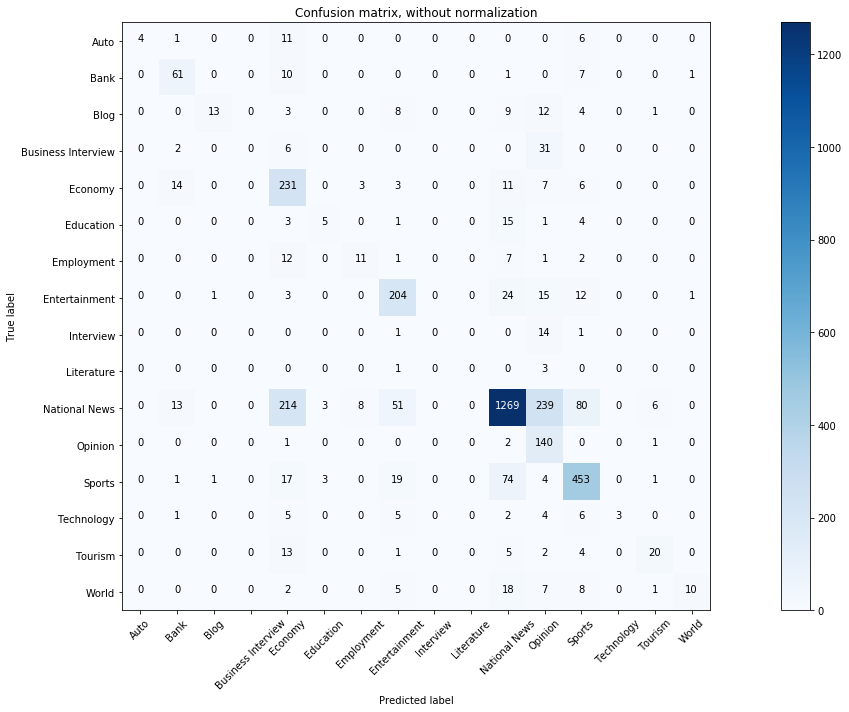

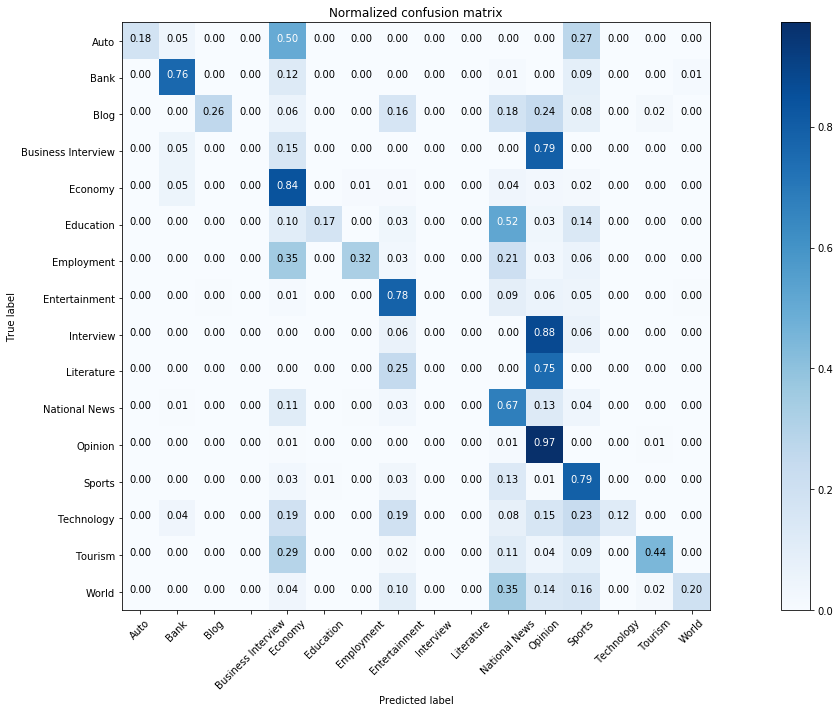

In [44]:
display_confusion_mat(y_pred=y_pred, gt=pd_test.label)

In [45]:
acc, prec, recall, val = calc_acc_prec_recall(y_pred, pd_test.label)
print(val)

Accuracy: 0.6864910790144435
Precision: 1.0
Recall: 1.0
Number of True Positive: 61
Number of False Positive: 0
Number of False Negative: 0
Number of True Negative: 13
[61, 0, 0, 13]


In [46]:
%%time
'''
    Cross Validation Logistic Regression
'''
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np

cv_ovr = LogisticRegression()

cv_ovr = cross_validate(cv_ovr, train_vectorized, pd_train.label.values, scoring='accuracy', n_jobs=-1, cv=5)

Wall time: 26.2 s


In [47]:
print(cv_ovr['test_score'])

[0.56 0.6  0.53 0.55 0.57]


In [48]:
print('Cross-validation mean (test) accuracy {0:.2f}%, std {1:.2f}.'.format(np.mean(cv_ovr['test_score']) * 100, np.std(cv_ovr['test_score']) * 100))

Cross-validation mean (test) accuracy 56.34%, std 2.22.


##  GridSearch CV Logistic Regression

In [64]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

ovr = LogisticRegression()

param_grid = {'C': [1, 10, 100, 1000] }

ovr_grid = GridSearchCV(ovr, param_grid=param_grid, cv=5, refit=True, verbose=1)

filename='./data/models/logistic_cv.pkl'

if os.path.exists(filename):
    ovr_grid_fit = load_model(filename=filename)
else:
    ovr_grid_fit = ovr_grid.fit(train_vectorized, pd_train.label.values)

Wall time: 31.2 ms


In [238]:
ovr_grid_fit.best_estimator_

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [65]:
ovr_grid_score = ovr_grid_fit.score(test_vectorized, pd_test.label.values)
print_acc(acc=ovr_grid_score, est='Logistic Regression CV')

Accuracy of Logistic Regression CV: 77.145%


In [66]:
# Testing with random new review
print_prediction(review, ovr_grid_fit)

*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: National News
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Sports
बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। : Blog


In [63]:
# Save model
save_model(ovr_grid_fit, filename='./data/models/logistic_cv.pkl')

## Support Vector Machine

In [44]:
%%time
'''
    SVM
'''

from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

svm = OneVsRestClassifier(SVC(C=1, kernel='sigmoid'))

filename='./data/models/svm.pkl'

if os.path.exists(filename):
    svm = load_model(filename=filename)
else:
    svm = svm.fit(train_vectorized, pd_train.label.values)

CPU times: user 1min 41s, sys: 0 ns, total: 1min 41s
Wall time: 1min 41s


In [45]:
svm_acc = svm.score(test_vectorized, pd_test.label.values)
print('SVM accuracy', svm_acc)

SVM accuracy 0.6230529595015576


In [46]:
save_model(model=svm, filename=filename)

In [47]:
# Evaluate the trained algorithm with new data
print_prediction(review, svm)

*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Entertainment
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Sports
अर्ब ६३ करोड ६३ लाख ३९ हजार ५६० मूल्य बराबरको शेयर किनबेच भएको छ। नेपालस्टक एक्चेन्ज(नेप्से) परिसूचक साताभारमा १७ अंकले बढेको छ।: Bank


/home/osingh1/miniconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


## Grid Search CV SVM

In [ ]:
%%time
'''
    Grid Search CV SVM
'''
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

svm_grid = SVC()

param_grid = {'C': [0.1, 1, 10], 'gamma': [1e-3, 1e-4]}

svm_grid = GridSearchCV(svm_grid, param_grid=param_grid, cv=5, refit=True, verbose=1)

svm_grid_fit = svm_grid.fit(train_vectorized, pd_train.label.values)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


## Multinomial Naive Bayes

In [231]:
%%time
'''
    Naive Bayes MultinomialNB
'''

from sklearn.naive_bayes import MultinomialNB, BernoulliNB 

nb_clf = MultinomialNB()
nb_clf.fit(X=train_vectorized, y=pd_train.label.values)
nb_score = nb_clf.score(test_vectorized, pd_test.label.values)

print_acc('MultinomialNB', nb_score)

print_prediction(review, nb_clf)

Accuracy of MultinomialNB: 22.175%
*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Opinion
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Economy
बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। : Opinion
CPU times: user 780 ms, sys: 12 ms, total: 792 ms
Wall time: 794 ms


## Bernoulli Naive Bayes

In [82]:
%%time
'''
    Naive Bayes BernoulliNB
'''

nb_bern_clf = BernoulliNB()
nb_bern_clf.fit(X=train_vectorized, y=pd_train.label.values)
nb_bern_score = nb_bern_clf.score(test_vectorized, pd_test.label.values)

print_acc('BernoulliNB', nb_bern_score)

print_prediction(review, nb_bern_clf)

Accuracy of MultinomialNB: 59.360%
*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Sports
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Sports
बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। : Sports
Wall time: 484 ms


## kNN Classifier

In [83]:
%%time
'''
    KNN Classifier
'''

from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X=train_vectorized, y=pd_train.label.values)
knn_score = knn_clf.score(test_vectorized, pd_test.label.values)

print_acc('KNN Classifier', knn_score)

print_prediction(review, knn_clf)

Accuracy of KNN Classifier: 17.644%
*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Opinion
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Opinion
बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। : Opinion
Wall time: 6.69 s


## GridSearch CV kNN Classifier

In [84]:
%%time
'''
    Grid Search CV kNN Classifier
'''
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn_clf_grid = KNeighborsClassifier()

param_grid = {'n_neighbors': [1, 2, 3, 5, 10]}

knn_clf_grid = GridSearchCV(knn_clf_grid, param_grid=param_grid, cv=5, refit=True, verbose=1)

knn_grid_fit = knn_clf_grid.fit(train_vectorized, pd_train.label.values)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 2min 30s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.5min finished


In [88]:
print_acc(acc=knn_grid_fit.best_score_, est='GridSearch kNN')

print_prediction(review, knn_grid_fit.best_estimator_)

Accuracy of GridSearch kNN: 31.736%
*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Opinion
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Opinion
बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। : Economy


In [92]:
print(knn_grid_fit.best_estimator_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')


## Perceptron

In [363]:
%%time
'''
    Perceptron
'''

from sklearn.linear_model import Perceptron

percept = Perceptron(alpha=0.00001, tol=1e-5, penalty='l2', random_state=1, max_iter=1000)
percept = percept.fit(X=train_vectorized, y=pd_train.label.values)
percept_score = percept.score(test_vectorized, pd_test.label.values)

print_acc('Perceptron Classifier', percept_score)

Accuracy of Perceptron Classifier: 77.004%
CPU times: user 828 ms, sys: 4 ms, total: 832 ms
Wall time: 830 ms


In [364]:
percept_predict = percept.predict(test_vectorized)

In [365]:
print_prediction(review, percept)

*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: National News
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Sports
अर्ब ६३ करोड ६३ लाख ३९ हजार ५६० मूल्य बराबरको शेयर किनबेच भएको छ। नेपालस्टक एक्चेन्ज(नेप्से) परिसूचक साताभारमा १७ अंकले बढेको छ।: Economy


## GridSearchCV Perceptron

In [368]:
%%time
'''
    Grid Search CV Perceptron
'''
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Perceptron

percept_grid = Perceptron(n_jobs=-1)

param_grid = {'alpha':[0.000001, 0.00001, 0.0001],'max_iter': [1000, 2000, 3000],
              'tol':[1e-5, 1e-4, 1e-3], 'penalty':['l2', 'l1', 'None'],
             'class_weight':['balanced', None]}

percept_grid = GridSearchCV(percept_grid, param_grid=param_grid, cv=5, refit=True, verbose=1)

percept_grid_fit = percept_grid.fit(train_vectorized, pd_train.label.values)

/home/osingh1/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:  6.3min finished


CPU times: user 45min 52s, sys: 9.12 s, total: 46min 1s
Wall time: 6min 21s


In [369]:
print_acc('GridSearch CV Perceptron Classifier', percept_grid_fit.best_score_)

print_prediction(review, percept_grid_fit.best_estimator_)

Accuracy of GridSearch CV Perceptron Classifier: 66.605%
*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Economy
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Economy
अर्ब ६३ करोड ६३ लाख ३९ हजार ५६० मूल्य बराबरको शेयर किनबेच भएको छ। नेपालस्टक एक्चेन्ज(नेप्से) परिसूचक साताभारमा १७ अंकले बढेको छ।: Economy


/home/osingh1/miniconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [373]:
percept_grid_fit.best_estimator_

Perceptron(alpha=1e-06, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=1000, n_iter=None, n_jobs=-1, penalty='l1', random_state=0,
      shuffle=True, tol=0.0001, verbose=0, warm_start=False)

In [372]:
print_prediction(review, percept_grid_fit)

*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Economy
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Economy
अर्ब ६३ करोड ६३ लाख ३९ हजार ५६० मूल्य बराबरको शेयर किनबेच भएको छ। नेपालस्टक एक्चेन्ज(नेप्से) परिसूचक साताभारमा १७ अंकले बढेको छ।: Economy


## Multi Layered Perceptron - lbfgs

In [377]:
%%time
'''
    Multi Layered Perceptron - lbfgs
'''

from sklearn.neural_network import MLPClassifier

mlp_lbfgs = MLPClassifier(solver='lbfgs', alpha=1e-5, tol=1e-5,
                    hidden_layer_sizes=(100, 50, 25), random_state=1,
                   max_iter=1000)

filename='./data/models/mlp_lbfgs.pkl'

if os.path.exists(filename):
    mlp_lbfgs = load_model(filename)
else:
    mlp_lbfgs.fit(X=train_vectorized, y=pd_train.label.values)
    save_model(mlp_lbfgs, filename=filename)

mlp_lbfgs_score = mlp_lbfgs.score(test_vectorized, pd_test.label.values)

print_acc('MultiLayered Perceptron Classifier - lbfgs', mlp_lbfgs_score)

Accuracy of MultiLayered Perceptron Classifier: 67.431%
CPU times: user 3h 28min 34s, sys: 11.4 s, total: 3h 28min 46s
Wall time: 13min 16s


In [379]:
print_prediction(review, mlp_lbfgs)

*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Education
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Tourism
अर्ब ६३ करोड ६३ लाख ३९ हजार ५६० मूल्य बराबरको शेयर किनबेच भएको छ। नेपालस्टक एक्चेन्ज(नेप्से) परिसूचक साताभारमा १७ अंकले बढेको छ।: Tourism


## Multi Layered Perceptron - sgd

In [45]:
%%time
'''
    Multi Layered Perceptron - sgd
'''

from sklearn.neural_network import MLPClassifier

mlp_sgd = MLPClassifier(solver='sgd', alpha=1e-5, tol=1e-5,
                    hidden_layer_sizes=(100, 50, 25), random_state=1,
                   max_iter=1000)

filename='./data/models/mlp_sgd.pkl'

if os.path.exists(filename):
    mlp_sgd = load_model(filename)
else:
    mlp_sgd.fit(X=train_vectorized, y=pd_train.label.values)
    save_model(mlp_sgd, filename=filename)

mlp_sgd_score = mlp_sgd.score(test_vectorized, pd_test.label.values)

print_acc('MultiLayered Perceptron Classifier - sgd', mlp_sgd_score)

/home/osingh1/miniconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy of MultiLayered Perceptron Classifier - sgd: 70.405%
CPU times: user 3d 6h 59min 40s, sys: 10min 14s, total: 3d 7h 9min 55s
Wall time: 1h 41min 55s


In [46]:
print_prediction(review, mlp_sgd)

*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: World
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: National News
अर्ब ६३ करोड ६३ लाख ३९ हजार ५६० मूल्य बराबरको शेयर किनबेच भएको छ। नेपालस्टक एक्चेन्ज(नेप्से) परिसूचक साताभारमा १७ अंकले बढेको छ।: Employment


## Multi Layered Perceptron - adam

In [47]:
%%time
'''
    Multi Layered Perceptron - adam
'''

from sklearn.neural_network import MLPClassifier

mlp_adam = MLPClassifier(solver='adam', alpha=1e-5, tol=1e-5,
                    hidden_layer_sizes=(100, 50, 25), random_state=1,
                   max_iter=1000)

filename='./data/models/mlp_adam.pkl'

if os.path.exists(filename):
    mlp_adam = load_model(filename)
else:
    mlp_adam.fit(X=train_vectorized, y=pd_train.label.values)
    save_model(mlp_adam, filename=filename)

mlp_adam_score = mlp_adam.score(test_vectorized, pd_test.label.values)

print_acc('MultiLayered Perceptron Classifier - adam', mlp_adam_score)

Accuracy of MultiLayered Perceptron Classifier - adam: 66.553%
CPU times: user 4h 19min 24s, sys: 41.4 s, total: 4h 20min 6s
Wall time: 7min 57s


In [48]:
print_prediction(review, mlp_adam)

*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Employment
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Education
अर्ब ६३ करोड ६३ लाख ३९ हजार ५६० मूल्य बराबरको शेयर किनबेच भएको छ। नेपालस्टक एक्चेन्ज(नेप्से) परिसूचक साताभारमा १७ अंकले बढेको छ।: Economy


## Gradient Boosting Classifier

In [261]:
%%time
'''
    Gradient Boosting Classifier
'''

from sklearn.ensemble import GradientBoostingClassifier

grad_boost = GradientBoostingClassifier()

filename='./data/models/grad_boost.pkl'

if os.path.exists(filename):
    grad_boost = load_model(filename)
else:
    grad_boost.fit(train_vectorized, pd_train.label.values)

grad_boost_score = grad_boost.score(test_vectorized, pd_test.label.values)

CPU times: user 41min 31s, sys: 156 ms, total: 41min 31s
Wall time: 41min 31s


In [263]:
print_acc('Gradient Boosting Classifier', grad_boost_score)

Accuracy of Gradient Boosting Classifier: 77.485%


In [264]:
save_model(grad_boost, filename='./data/models/grad_boost.pkl')

In [266]:
print_prediction(review, grad_boost)

*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Entertainment
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Sports
बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। : World


## Bagging Classifier

In [234]:
%%time
'''
    Bagging Classifier
'''

from sklearn.ensemble import BaggingClassifier

bagg = BaggingClassifier()

filename='./data/models/bagg.pkl'

if os.path.exists(filename):
    bagg = load_model(filename)
else:
    bagg.fit(train_vectorized, pd_train.label.values)

bagg_score = bagg.score(test_vectorized, pd_test.label.values)

Wall time: 1min 41s


In [236]:
print_acc('Bagging Classifier', bagg_score)

Accuracy of Bagging Classifier: 77.287%


In [237]:
print_prediction(review, bagg)

*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Economy
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Economy
बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। : Technology


## SGD Classifier

In [255]:
%%time
'''
    SGD Classifier
'''

from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(max_iter=2000, n_jobs=-1, class_weight='balanced')

filename='./data/models/sgd.pkl'

if os.path.exists(filename):
    sgd = load_model(filename)
else:
    sgd.fit(train_vectorized, pd_train.label.values)

sgd_score = sgd.score(test_vectorized, pd_test.label.values)

CPU times: user 11min 12s, sys: 96 ms, total: 11min 13s
Wall time: 1min 7s


In [258]:
save_model(sgd, filename=filename)

In [259]:
print_acc('SGD Classifier', sgd_score)

Accuracy of SGD Classifier: 69.924%


In [257]:
print_prediction(review, sgd)

*****EVALUATE REVIEW*******
सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Blog
आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Sports
बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। : Blog


/home/osingh1/miniconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [262]:
# PRECISION-RECALL plot

# VISUALIZATION SECTION STARTS

### NOTE: WORDCLOUD IS NOT WORKING WITH DEVNAGARI CHARACTER

In [140]:
%%time
'''
    Collocate Cloud Visualization
'''

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import unicodedata as un

new_train_tokens = [x.encode('utf-8').decode('utf-8') for x in train_tokens_list]

Wall time: 125 ms


In [207]:
from arabic_reshaper import arabic_reshaper
from bidi.algorithm import get_display

text = open('./data/clean_corpus/Auto_corpus_proc.txt', encoding='utf-8').read()
text = arabic_reshaper.reshape(text)
text = get_display(arabic_reshaper.reshape(text))



In [209]:
wordcloud = WordCloud(width=480, 
                      height=240, 
                      margin=0,
                      regexp=r"[\u0900-\u097F]+").generate(text)

In [210]:
def draw_cloud(word_cloud, title):
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.margins(x=0, y=0)
    plt.show()

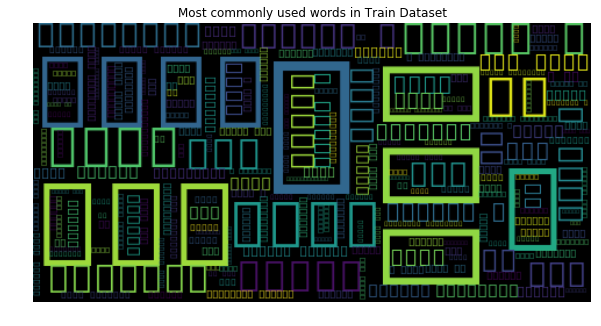

In [211]:
draw_cloud(wordcloud, title="Most commonly used words in Train Dataset")

In [212]:
wordcloud_test = WordCloud(width=480, height=240, margin=0).generate(str(test_tokens_list))

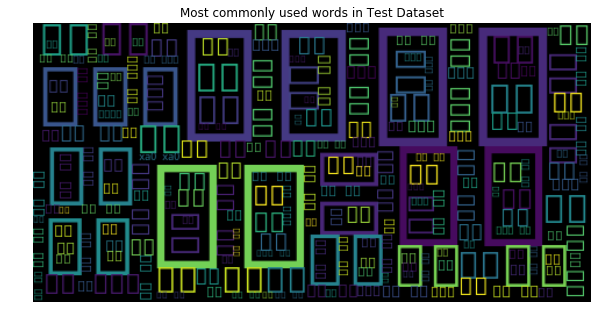

In [213]:
draw_cloud(wordcloud_test, title="Most commonly used words in Test Dataset")

In [214]:
'''
    Top 100 words
'''

# Creating stop words
text_unigram = ngrams(tokens, 1)

# Most common 50 words
stop_words = Counter(text_unigram).most_common(50)

stop_word_list = []
for item in stop_words:
    stop_word_list += item[0]

print(stop_word_list)

['छ', 'र', 'पनि', 'हो', 'छन्', 'भने', 'भएको', 'लागि', 'गर्न', 'गर्ने', 'गरेको', 'यो', 'तर', 'नै', 'थियो', 'तथा', 'भन्ने', 'हुने', 'छैन', 'एक', 'त', 'उनले', 'नेपाल', 'काम', 'गरेका', 'कुरा', 'थिए', 'हुन्छ', 'रहेको', 'केही', 'नेपाली', 'अहिले', 'आफ्नो', 'मात्र', 'हुन', 'कुनै', 'गरी', 'त्यो', 'के', 'नयाँ', 'गरिएको', 'कारण', 'धेरै', 'भएका', 'गरेर', 'गर्दै', 'रुपमा', 'हजार', 'भए', 'हुन्']


In [215]:
# Removed the words present in stop_word_list
filtered_tokens = [w for w in tokens if not w in stop_word_list] 

In [216]:
# Created unigram
filtered_text_unigram = ngrams(filtered_tokens, 1)

# Create counter
text_uni = Counter(filtered_text_unigram).most_common(100)

In [217]:
# Created dictionary for top 100 words
uni_dict = {}
for each in text_uni:
    uni_dict[each[0][0]] = each[1]

In [218]:
# Created word cloud for top 100 words
top_word_cloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(uni_dict)

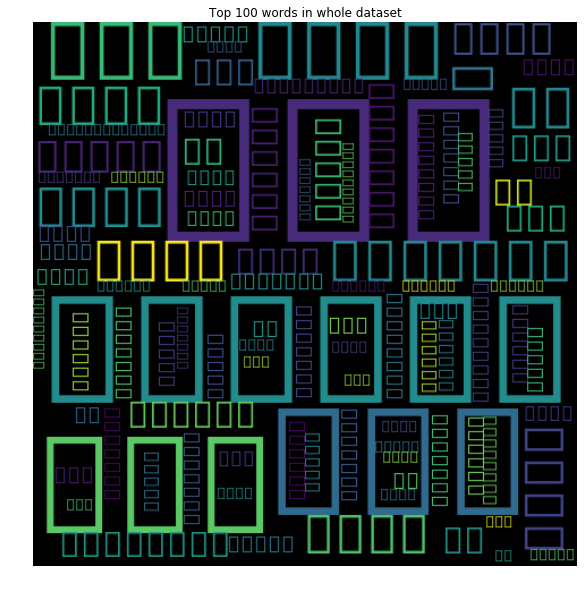

In [219]:
draw_cloud(top_word_cloud, title="Top 100 words in whole dataset")

In [220]:
# Created unigram
filtered_text_unigram = ngrams(filtered_tokens, 1)

# Create counter for least commonly used words
text_uni_least = Counter(filtered_text_unigram).most_common()[-100:]

In [221]:
# Created dictionary for least 100 words
uni_dict_least = {}
for each in text_uni_least:
    uni_dict_least[each[0][0]] = each[1]

In [222]:
# Created word cloud for least 100 words
least_word_cloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(uni_dict_least)

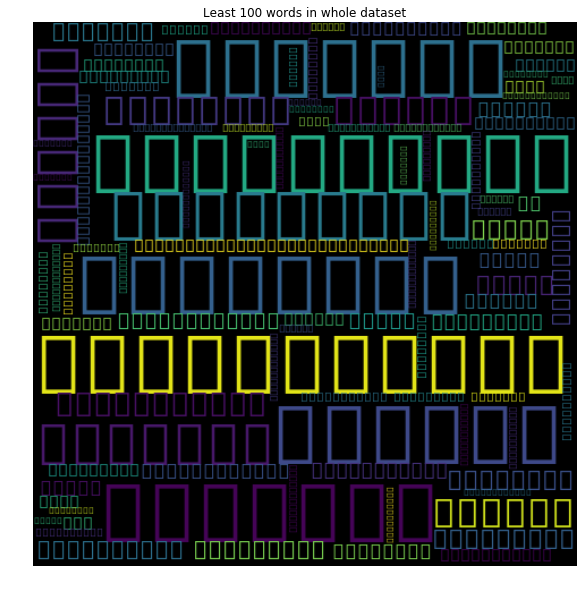

In [223]:
draw_cloud(least_word_cloud, title="Least 100 words in whole dataset")

In [224]:
'''
    Top words for bigrams
'''

# Creating stop words
text_bigram = ngrams(tokens, 2)

# Create counter
text_bi = Counter(text_bigram).most_common(100)

In [225]:
# Created dictionary for top 100 bigrams
bi_dict = {}
for each in text_bi:
    # Merge bigram words
    merged = each[0][0] + ' ' + each[0][1]
    bi_dict[merged] = each[1]

In [226]:
# Created word cloud for top 100 bigrams
bigram_cloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(bi_dict)

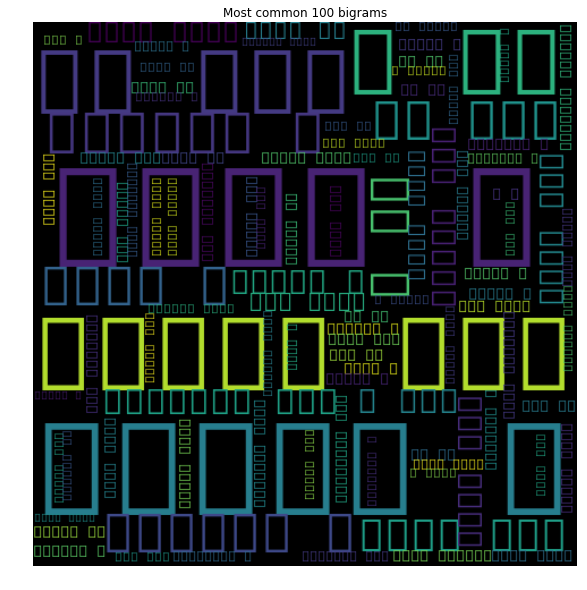

In [227]:
draw_cloud(bigram_cloud, title="Most common 100 bigrams")

In [228]:
'''
    Top words for Trigrams
'''

# Creating stop words
text_trigram = ngrams(tokens, 3)

# Create counter
text_tri = Counter(text_trigram).most_common(100)

In [229]:
# Created dictionary for top 100 bigrams
tri_dict = {}
for each in text_tri:
    # Merge trigram words
    merged = each[0][0] + ' ' + each[0][1] + ' ' + each[0][2]
    tri_dict[merged] = each[1]

In [230]:
# Created word cloud for top 100 bigrams
trigram_cloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(tri_dict)

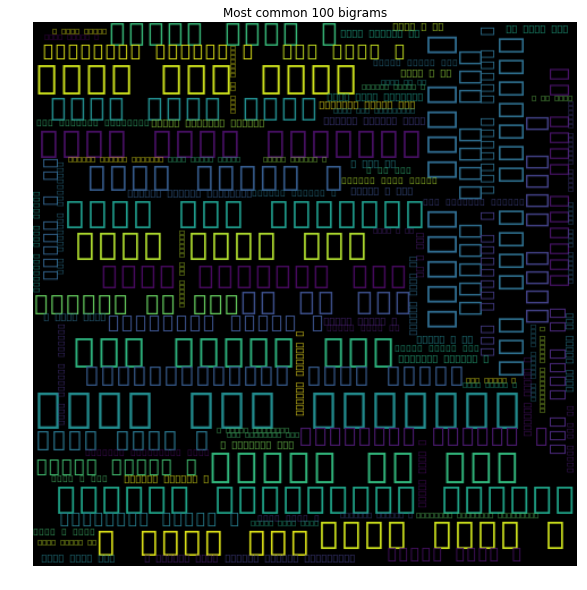

In [231]:
draw_cloud(trigram_cloud, title="Most common 100 bigrams")